In [2]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sqlite3
import warnings
from scipy.stats import linregress
warnings.filterwarnings('ignore')

Function that is useful


In [3]:
def get_stock_data_by_symbol_and_date(conn, symbol, start_date='2020-01-01', end_date='2024-12-31'):
    query = """
    SELECT *
    FROM stock_data
    WHERE 證券代號 = ?
    AND 交易日期 BETWEEN ? AND ?
    """
    df = pd.read_sql_query(query, conn, params=[symbol, start_date, end_date])
    
    df = df.sort_values(by='交易日期')
    
    # Columns we want to convert to float.
    # columns_to_float = [
    #     '成交股數', '成交筆數', '成交金額',
    #     '開盤價', '最高價', '最低價', '收盤價',
    #     '漲跌價差',
    #     '最後揭示買價', '最後揭示買量', '最後揭示賣價', '最後揭示賣量',
    #     '本益比'
    # ]
    
    # for col in columns_to_float:
    #     # Convert to string, remove commas, then convert to numeric.
    #     df[col] = (
    #         df[col]
    #         .astype(str)                     # Ensure values are strings
    #         .str.replace(',', '', regex=True)  # Remove all commas
    #     )
    #     df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float (NaN where invalid)
    
    return df

In [26]:
def Pick_percent_data(test_df, start_date="2020-01-01", end_date="2020-12-31", price_col="收盤價", stock_id_col="證券代號", pick="top", pct=0.01):
    mask = (test_df["交易日期"] >= start_date) & (test_df["交易日期"] <= end_date)
    stock_2020_2021 = test_df.loc[mask].copy()
    
    stock_2020_2021["return"] = stock_2020_2021.groupby(stock_id_col)[price_col].pct_change()
    
    grouped = stock_2020_2021.groupby(stock_id_col)[price_col]
    overall = pd.DataFrame((grouped.last() - grouped.first()) / grouped.first(), columns=["return"])
    overall.sort_values(by="return", ascending=False, inplace=True)
    
    top_count = int(len(overall) * pct)
    
    if pick.lower() == "top":
        selected = overall.head(top_count)
    else:
        selected = overall.tail(int(len(overall) * 0.01))
    
    return selected

In [33]:

def plot_top_last_pe_relationship(top_1_percent, last_1_percent, stock_2020_2021, price_col='本益比'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Top 1% subplot (left)
    y_top = top_1_percent["return"] * 100
    x_top = stock_2020_2021[stock_2020_2021["證券代號"].isin(top_1_percent.index)] \
        .groupby("證券代號")[price_col].last()
    common_index_top = x_top.index.intersection(y_top.index)
    x_top = x_top.loc[common_index_top]
    y_top = y_top.loc[common_index_top]
    slope_top, intercept_top, _, _, _ = linregress(x_top, y_top)
    reg_line_top = slope_top * x_top + intercept_top
    cmap_top = plt.cm.get_cmap("tab10", len(common_index_top))
    for i, stock in enumerate(common_index_top):
        axes[0].scatter(x_top.loc[stock], y_top.loc[stock], color=cmap_top(i), s=50, label=stock)
    axes[0].plot(x_top, reg_line_top, color='red', label='迴歸線')
    axes[0].set_xlabel('本益比')
    axes[0].set_ylabel('回報 (%)')
    axes[0].set_title('top 1% 本益比與回報之間的關係')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Last 1% subplot (right)
    y_last = last_1_percent["return"] * 100
    x_last = stock_2020_2021[stock_2020_2021["證券代號"].isin(last_1_percent.index)] \
        .groupby("證券代號")[price_col].last()
    common_index_last = x_last.index.intersection(y_last.index)
    x_last = x_last.loc[common_index_last]
    y_last = y_last.loc[common_index_last]
    slope_last, intercept_last, _, _, _ = linregress(x_last, y_last)
    reg_line_last = slope_last * x_last + intercept_last
    cmap_last = plt.cm.get_cmap("tab10", len(common_index_last))
    for i, stock in enumerate(common_index_last):
        axes[1].scatter(x_last.loc[stock], y_last.loc[stock], color=cmap_last(i), s=50, label=stock)
    axes[1].plot(x_last, reg_line_last, color='red', label='迴歸線')
    axes[1].set_xlabel('本益比')
    axes[1].set_ylabel('回報 (%)')
    axes[1].set_title('last 1% 本益比與回報之間的關係')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [27]:
def plot_returns_and_std_per_column(df, stock_ids=None, price_col='收盤價', date_col='交易日期', window=20):
    """
    多檔股票, N 行 x 3 欄子圖:
      第 1 欄: 每日報酬率 (return)
      第 2 欄: 價格的滾動標準差 (price_std)
      第 3 欄: 報酬率的滾動標準差 (return_std)

    每個子圖使用自己的 y 軸範圍.
    """

    if stock_ids is None:
        stock_ids = df['證券代號'].unique()

    # 1. 日期處理與排序
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=['證券代號', date_col]).copy()
    df = df[df['證券代號'].isin(stock_ids)].copy()

    # 2. 計算日報酬率、價格標準差、報酬率標準差
    df['return'] = df.groupby('證券代號')[price_col].pct_change()
    df['price_std'] = df.groupby('證券代號')[price_col].rolling(window).std().reset_index(level=0, drop=True)
    df['return_std'] = df.groupby('證券代號')['return'].rolling(window).std().reset_index(level=0, drop=True)

    # 3. 建立 N 行 x 3 欄子圖 (不共用 y 軸範圍)
    n = len(stock_ids)
    fig, axes = plt.subplots(n, 3, figsize=(15, 3.5*n), sharex=True, constrained_layout=True)
    if n == 1:
        axes = axes.reshape(1, 3)  # 保證是 2D

    for row_idx, stock in enumerate(stock_ids):
        subdf = df[df['證券代號'] == stock].copy()
        subdf.set_index(date_col, inplace=True)

        ret_series = subdf['return']
        price_std_series = subdf['price_std']
        return_std_series = subdf['return_std']

        # 第 1 欄: 每日報酬率
        axes[row_idx, 0].plot(ret_series.index, ret_series, color='blue')
        axes[row_idx, 0].set_title(f"{stock} 日報酬率")
        axes[row_idx, 0].set_ylabel("報酬率")
        # 每個子圖自行調整 y 軸

        # 第 2 欄: 價格滾動標準差
        axes[row_idx, 1].plot(price_std_series.index, price_std_series, color='green')
        axes[row_idx, 1].set_title(f"{stock} {window}天價格標準差")
        # 每個子圖自行調整 y 軸

        # 第 3 欄: 報酬率滾動標準差
        axes[row_idx, 2].plot(return_std_series.index, return_std_series, color='red')
        axes[row_idx, 2].set_title(f"{stock} {window}天報酬率標準差")
        # 每個子圖自行調整 y 軸

        # 最後一行加上 x label
        if row_idx == n - 1:
            axes[row_idx, 0].set_xlabel("交易日期")
            axes[row_idx, 1].set_xlabel("交易日期")
            axes[row_idx, 2].set_xlabel("交易日期")

    plt.show()

# 使用新函數來繪圖 (每個子圖有獨立的 y 軸範圍)
# plot_returns_and_std_per_column(df_sample)

In [28]:

def get_nonzero_eps(group):
    stock_id = str(group.name)
    if len(stock_id) == 4:
        nonzero = group[group["EPS"] != 0]["EPS"]
        return nonzero.iloc[-1] if not nonzero.empty else 0
    else:
        return group["EPS"].iloc[-1]

def plot_top_last_eps_relationship(top_1_percent, last_1_percent, stock_2020_2021):
    grouped_eps = stock_2020_2021.groupby("證券代號").apply(get_nonzero_eps)
    
    common_index_top = grouped_eps.index.intersection(top_1_percent.index)
    x_top = grouped_eps.loc[common_index_top]
    y_top = top_1_percent.loc[common_index_top, "return"] * 100
    slope_top, intercept_top, _, _, _ = linregress(x_top, y_top)
    reg_line_top = slope_top * x_top + intercept_top

    common_index_last = grouped_eps.index.intersection(last_1_percent.index)
    x_last = grouped_eps.loc[common_index_last]
    y_last = last_1_percent.loc[common_index_last, "return"] * 100
    slope_last, intercept_last, _, _, _ = linregress(x_last, y_last)
    reg_line_last = slope_last * x_last + intercept_last

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    cmap_top = plt.cm.get_cmap("tab10", len(common_index_top))
    for i, stock in enumerate(common_index_top):
        axes[0].scatter(x_top.loc[stock], y_top.loc[stock], color=cmap_top(i), s=50, label=stock)
    axes[0].plot(x_top, reg_line_top, color='red', label='迴歸線')
    axes[0].set_xlabel('EPS')
    axes[0].set_ylabel('回報 (%)')
    axes[0].set_title('top 1% EPS與回報之間的關係')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    cmap_last = plt.cm.get_cmap("tab10", len(common_index_last))
    for i, stock in enumerate(common_index_last):
        axes[1].scatter(x_last.loc[stock], y_last.loc[stock], color=cmap_last(i), s=50, label=stock)
    axes[1].plot(x_last, reg_line_last, color='red', label='迴歸線')
    axes[1].set_xlabel('EPS')
    axes[1].set_ylabel('回報 (%)')
    axes[1].set_title('last 1% EPS與回報之間的關係')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [29]:
def plot_historical_volatility_by_stock(df, target_stock_ids, price_col='收盤價', window=20):
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    df = df.sort_values('交易日期')
    df = df[df["證券代號"].isin(target_stock_ids)]
    grouped = df.groupby("證券代號")

    # 計算 subplot 佈局
    n = len(grouped)
    cols = 3
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharex=True)
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # 收集所有股票的波動度序列，以便後續設定相同的 y 軸尺度
    vol_data = []
    vol_min, vol_max = float('inf'), float('-inf')

    for stock_id, group_df in grouped:
        group_df = group_df.sort_values('交易日期').set_index('交易日期')
        returns = group_df[price_col].pct_change()
        rolling_std = returns.rolling(window).std()
        valid_days = group_df[price_col].dropna().shape[0]
        annual_factor = np.sqrt(valid_days)
        vol = rolling_std * annual_factor
        vol_data.append((stock_id, vol))
        this_min, this_max = vol.min(), vol.max()
        if this_min < vol_min:
            vol_min = this_min
        if this_max > vol_max:
            vol_max = this_max

    # 畫圖並設定相同 y 軸尺度
    for i, (stock_id, vol) in enumerate(vol_data):
        axes[i].plot(vol.index, vol, label=f'{stock_id} (n={vol.count()})')
        axes[i].set_title(stock_id)
        axes[i].set_xlabel('交易日期')
        axes[i].set_ylabel('Volatility')
        axes[i].legend()
        axes[i].set_ylim(vol_min, vol_max)

    for j in range(i+1, rows*cols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [7]:
conn = sqlite3.connect("twse_data.db")

In [8]:
df = pd.read_sql_query("SELECT * FROM stock_data", conn)

In [9]:
df = df.sort_values(by='交易日期')
columns_to_float = [
        '成交股數', '成交筆數', '成交金額',
        '開盤價', '最高價', '最低價', '收盤價',
        '漲跌價差',
        '最後揭示買價', '最後揭示買量', '最後揭示賣價', '最後揭示賣量',
        '本益比'
    ]
    
for col in columns_to_float:
    # Convert to string, remove commas, then convert to numeric.
    df[col] = (
        df[col]
        .astype(str)                     # Ensure values are strings
        .str.replace(',', '', regex=True)  # Remove all commas
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float (NaN where invalid)


In [398]:
df.dtypes

證券代號        object
證券名稱        object
成交股數         int64
成交筆數         int64
成交金額         int64
開盤價        float64
最高價        float64
最低價        float64
收盤價        float64
漲跌(+/-)     object
漲跌價差       float64
最後揭示買價     float64
最後揭示買量     float64
最後揭示賣價     float64
最後揭示賣量     float64
本益比        float64
交易日期        object
dtype: object

In [399]:
df.isna().sum()

證券代號       0
證券名稱       0
成交股數       0
成交筆數       0
成交金額       0
開盤價        0
最高價        0
最低價        0
收盤價        0
漲跌(+/-)    0
漲跌價差       0
最後揭示買價     0
最後揭示買量     0
最後揭示賣價     0
最後揭示賣量     0
本益比        0
交易日期       0
dtype: int64

In [400]:
df.isnull().sum()

證券代號       0
證券名稱       0
成交股數       0
成交筆數       0
成交金額       0
開盤價        0
最高價        0
最低價        0
收盤價        0
漲跌(+/-)    0
漲跌價差       0
最後揭示買價     0
最後揭示買量     0
最後揭示賣價     0
最後揭示賣量     0
本益比        0
交易日期       0
dtype: int64

In [401]:
(df == 0).sum()

證券代號            0
證券名稱            0
成交股數        13632
成交筆數        13632
成交金額        13632
開盤價         16368
最高價         16368
最低價         16368
收盤價         16368
漲跌(+/-)         0
漲跌價差       153343
最後揭示買價       3668
最後揭示買量       3671
最後揭示賣價      14080
最後揭示賣量      14082
本益比        459353
交易日期            0
dtype: int64

In [402]:
df.describe()

,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比
count,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06,1.425192e+06
mean,4.299760e+06,1.880505e+03,2.584383e+08,6.809235e+01,6.907512e+01,6.705648e+01,6.796800e+01,1.162201e+00,6.791748e+01,1.978045e+02,6.761733e+01,8.004675e+01,2.783390e+01
std,1.893541e+07,6.172193e+03,1.418996e+09,1.644296e+02,1.674314e+02,1.611672e+02,1.639482e+02,5.160530e+00,1.633300e+02,3.009965e+03,1.633862e+02,6.818963e+02,1.366063e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.126595e+05,8.600000e+01,3.103500e+06,1.755000e+01,1.775000e+01,1.735000e+01,1.754000e+01,7.000000e-02,1.765000e+01,3.000000e+00,1.748000e+01,2.000000e+00,0.000000e+00
50%,5.122450e+05,3.530000e+02,1.668150e+07,3.200000e+01,3.240000e+01,3.170000e+01,3.200000e+01,2.500000e-01,3.205000e+01,1.000000e+01,3.190000e+01,7.000000e+00,1.222000e+01
75%,2.316948e+06,1.380000e+03,1.081245e+08,6.380000e+01,6.450000e+01,6.300000e+01,6.370000e+01,7.500000e-01,6.350000e+01,3.800000e+01,6.340000e+01,2.700000e+01,2.167000e+01
max,1.529134e+09,5.883730e+05,1.422155e+11,5.400000e+03,5.490000e+03,5.265000e+03,5.350000e+03,4.900000e+02,5.345000e+03,6.098580e+05,5.350000e+03,1.366310e+05,8.090000e+03


In [11]:
test = df.copy()

新增 EPS 

In [12]:
test["EPS"] = test["收盤價"] / test["本益比"]


In [13]:
test["EPS"].isna().sum()

14838

In [14]:
test["EPS"].fillna(0, inplace=True)

In [15]:
test.groupby("證券代號")["收盤價"].agg(["mean", "std", "min", "max"])


,mean,std,min,max
證券代號,,,,
0050,130.515337,27.682502,68.55,202.75
0051,57.921826,14.584991,24.78,86.55
0052,118.779523,32.703827,52.25,201.50
0053,65.428051,16.921320,30.80,110.10
0054,26.613213,7.108499,0.00,32.67
...,...,...,...,...
9944,21.032936,1.515865,13.20,28.65
9945,48.728495,12.455320,30.10,85.00
9946,18.398421,7.715073,9.18,49.55


## 2020~ 2024

In [16]:
stock_2020_2024 = test.copy()
stock_2020_2024 = stock_2020_2024[stock_2020_2024["收盤價"]!= 0]

In [17]:
stock_2020_2024["return"] = stock_2020_2024.groupby("證券代號")["收盤價"].pct_change()

In [18]:
grouped = stock_2020_2024.groupby("證券代號")["收盤價"]
overall_return = pd.DataFrame((grouped.last() - grouped.first()) / grouped.first())
overall_return.columns = ["return"]

In [19]:
overall_return.sort_values(by="return", ascending=False, inplace=True)

In [20]:
top_1_percent = overall_return.head(int(len(overall_return) * 0.01))

In [21]:
top_1_percent.index

Index(['2364', '3043', '1519', '2603', '6442', '3017', '1475', '2368', '3661',
       '2486', '2321', '3051', '2609'],
      dtype='object', name='證券代號')

In [22]:
last_1_percent = overall_return.tail(int(len(overall_return) * 0.01))

In [23]:
last_1_percent.index

Index(['6666', '2358', '2227', '4414', '8070', '6452', '4426', '6770', '6598',
       '2929', '1592', '4943', '00672L'],
      dtype='object', name='證券代號')

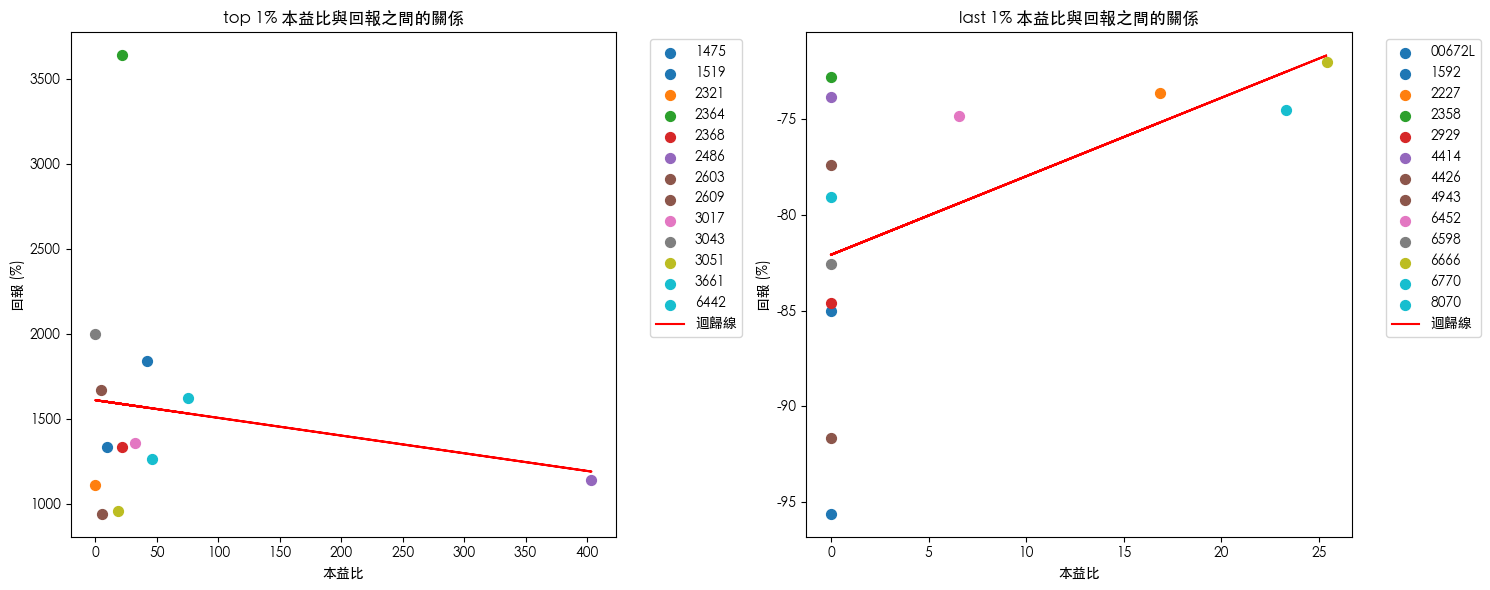

In [42]:
plot_top_last_pe_relationship(top_1_percent, last_1_percent, stock_2020_2024)

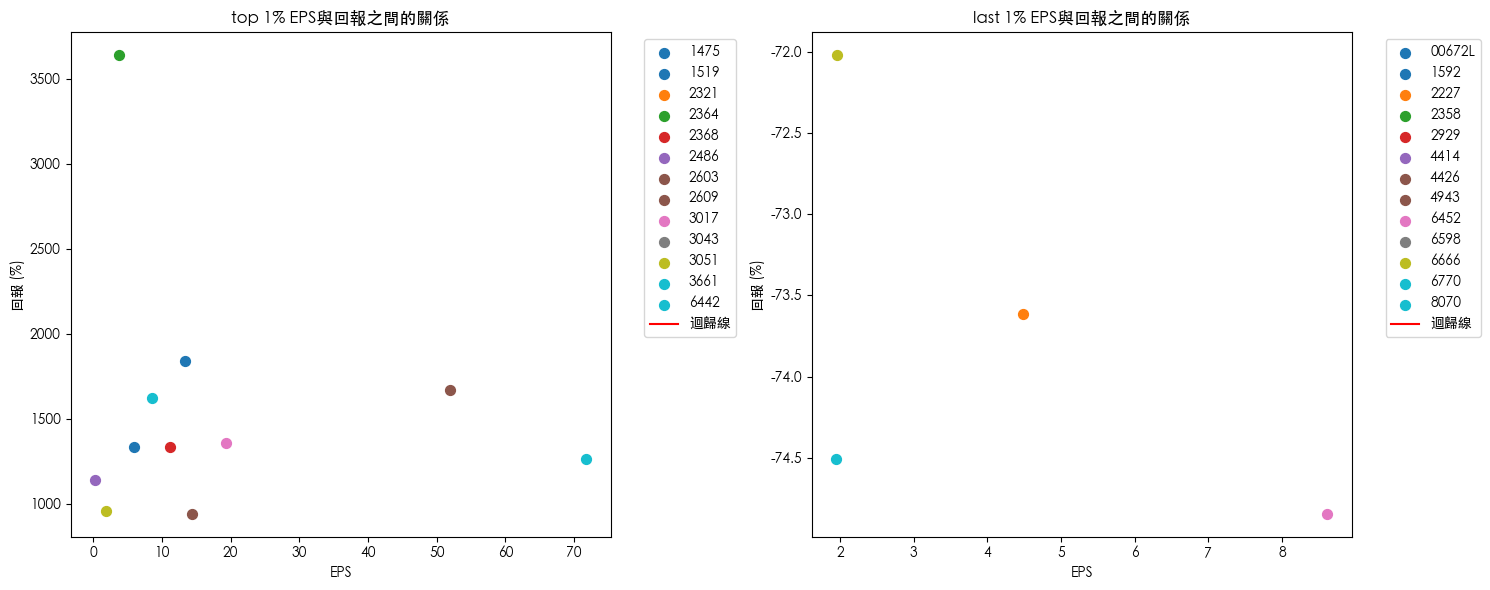

In [43]:
plot_top_last_eps_relationship(top_1_percent, last_1_percent, stock_2020_2024)

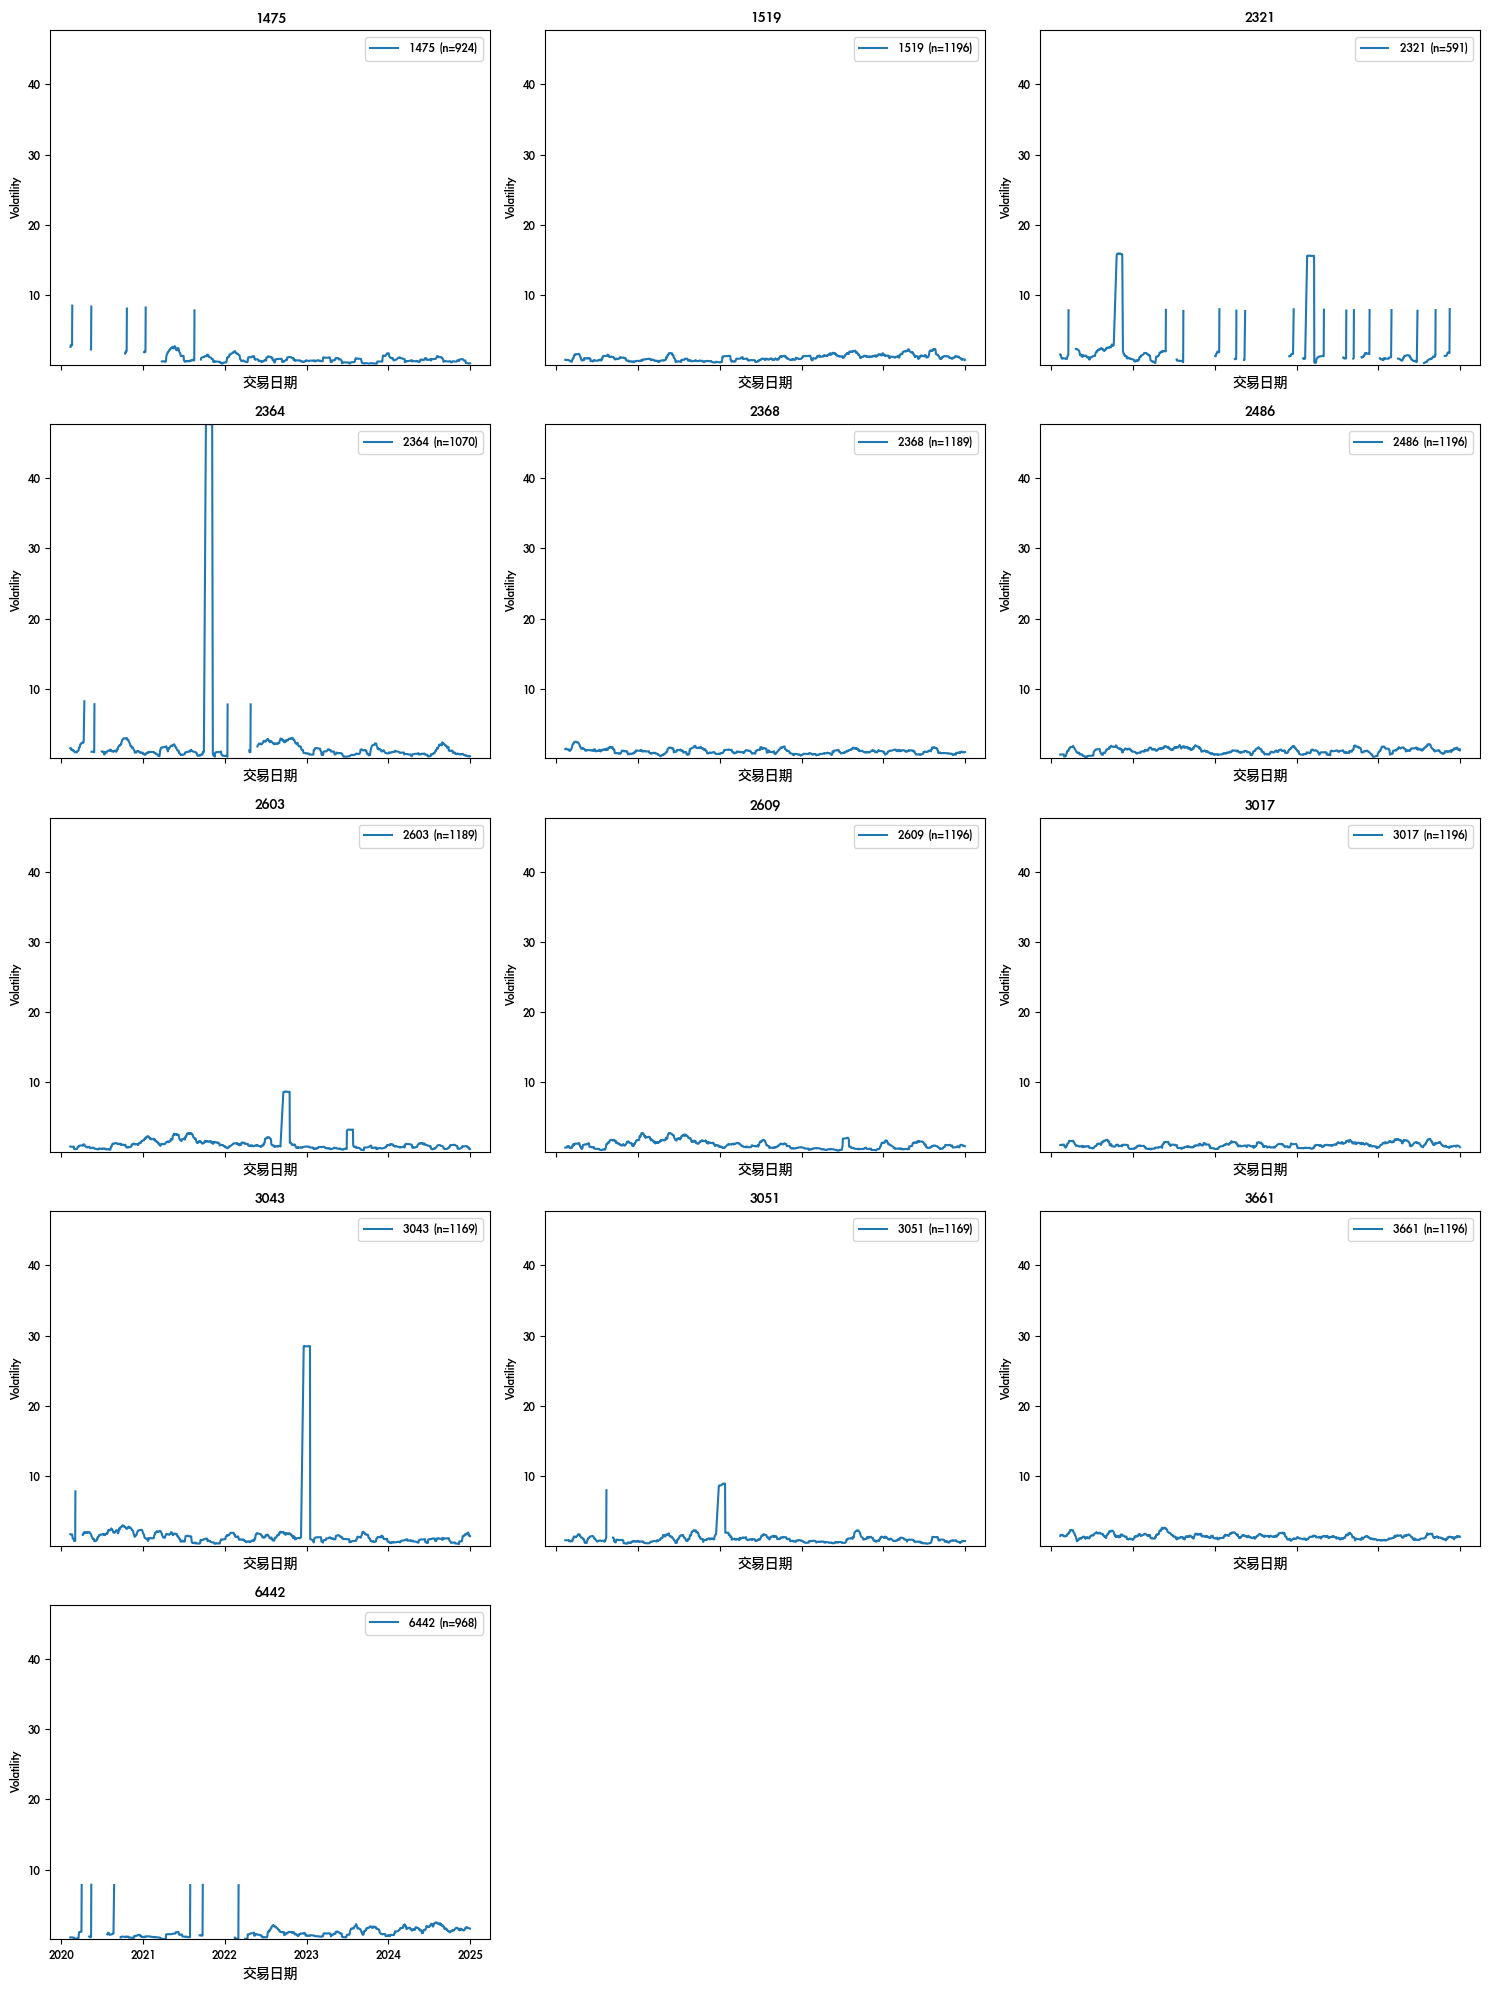

In [421]:
plot_historical_volatility_by_stock(df, top_1_percent.index)

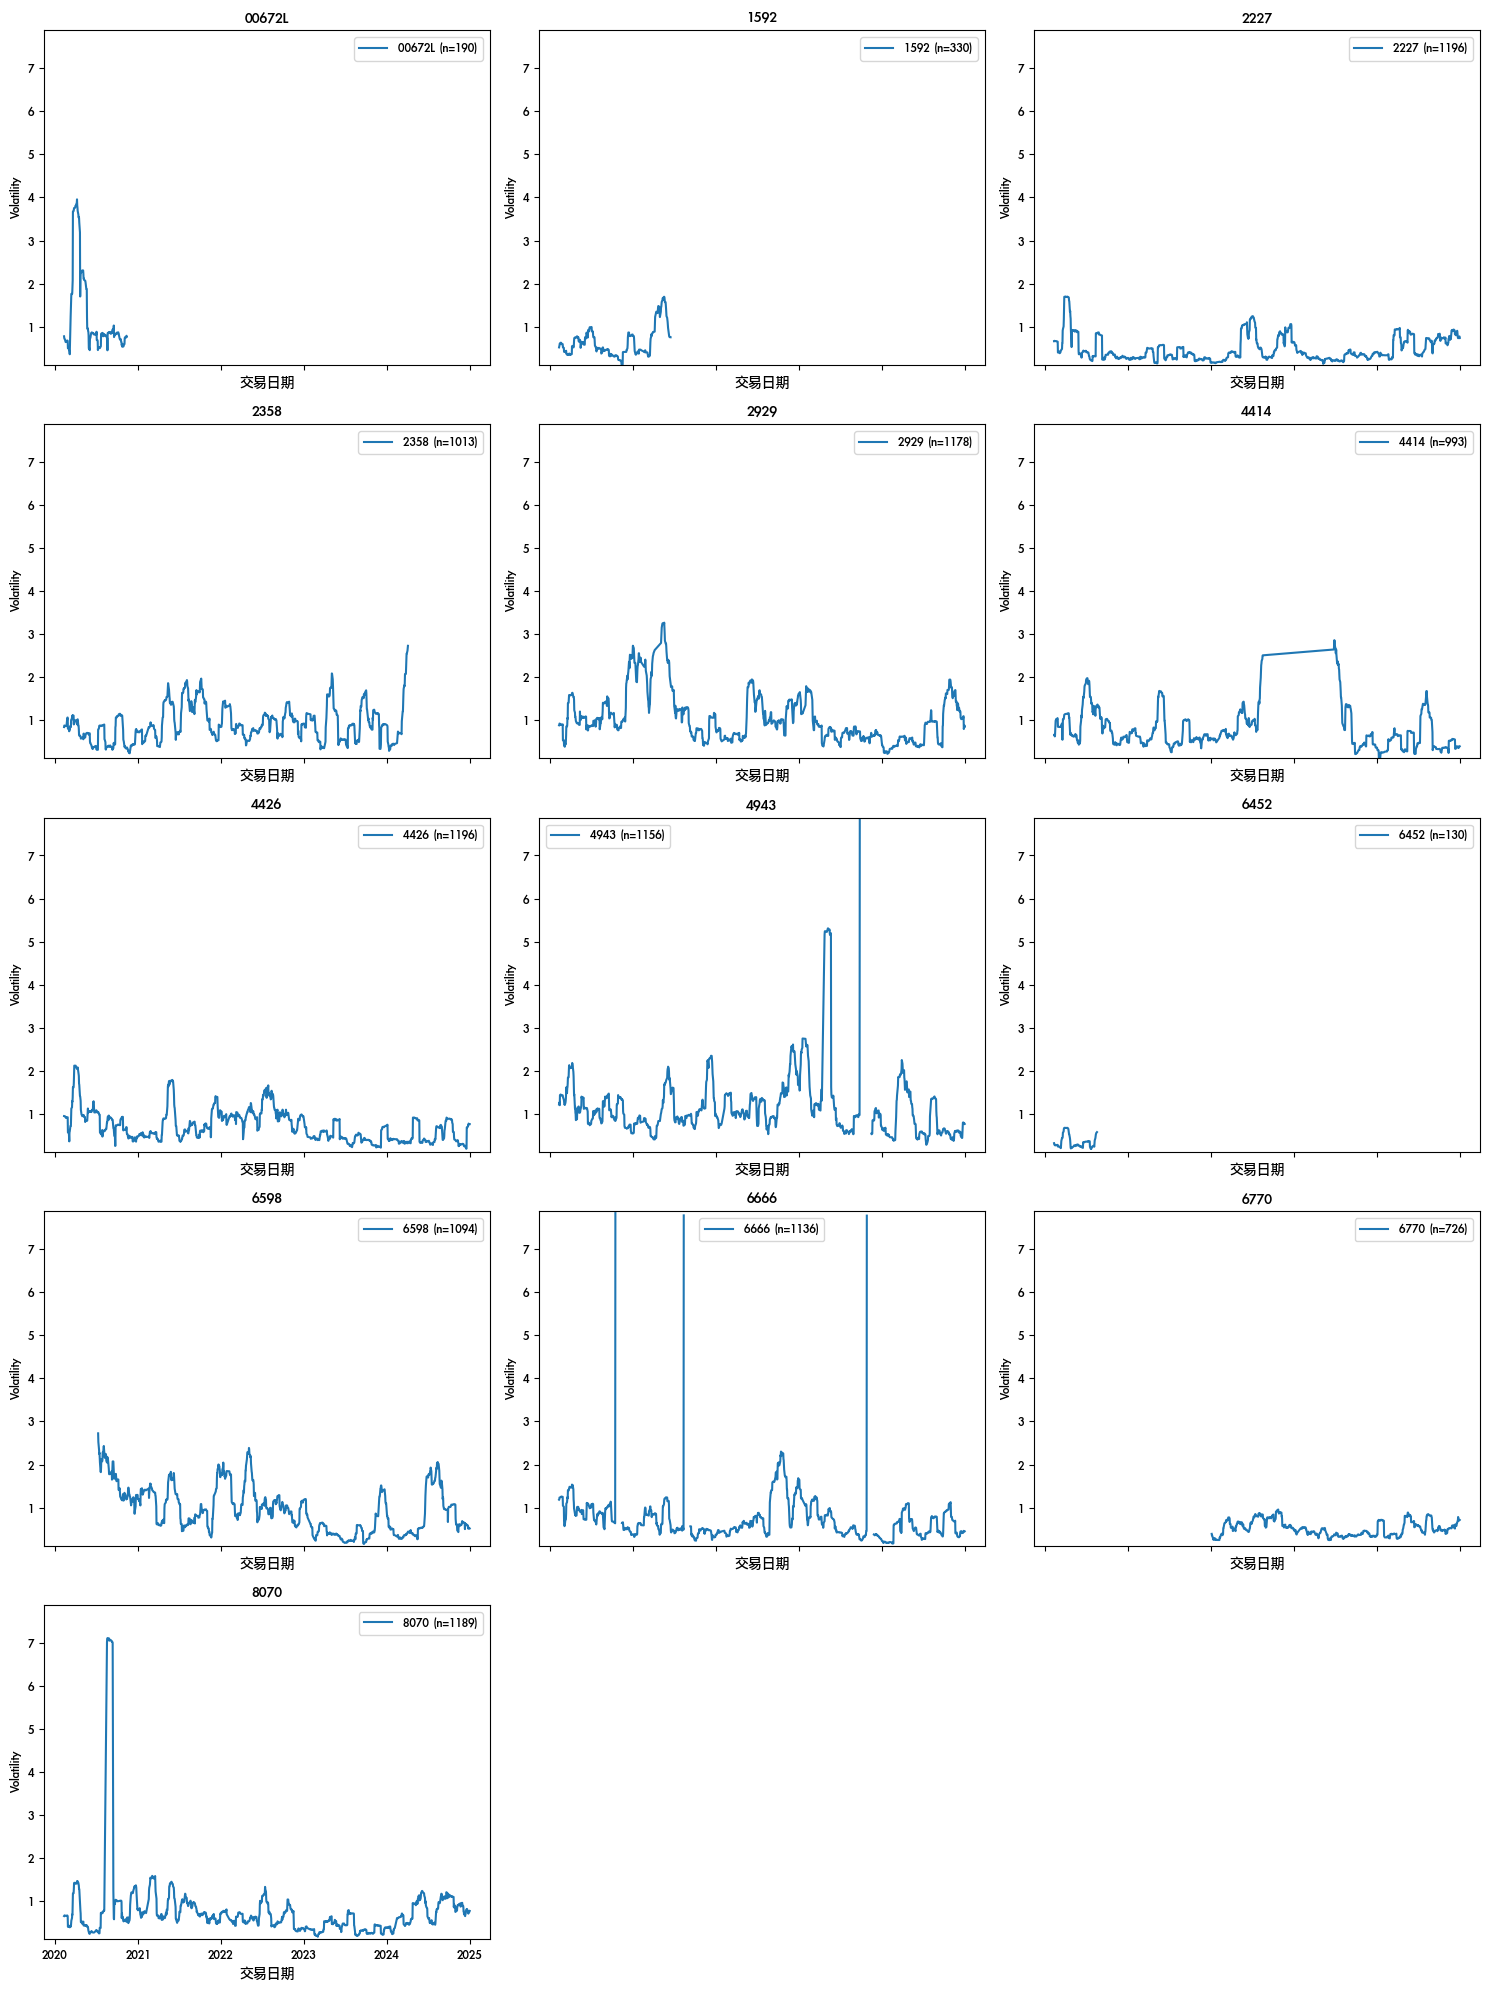

In [422]:
plot_historical_volatility_by_stock(df, last_1_percent.index)

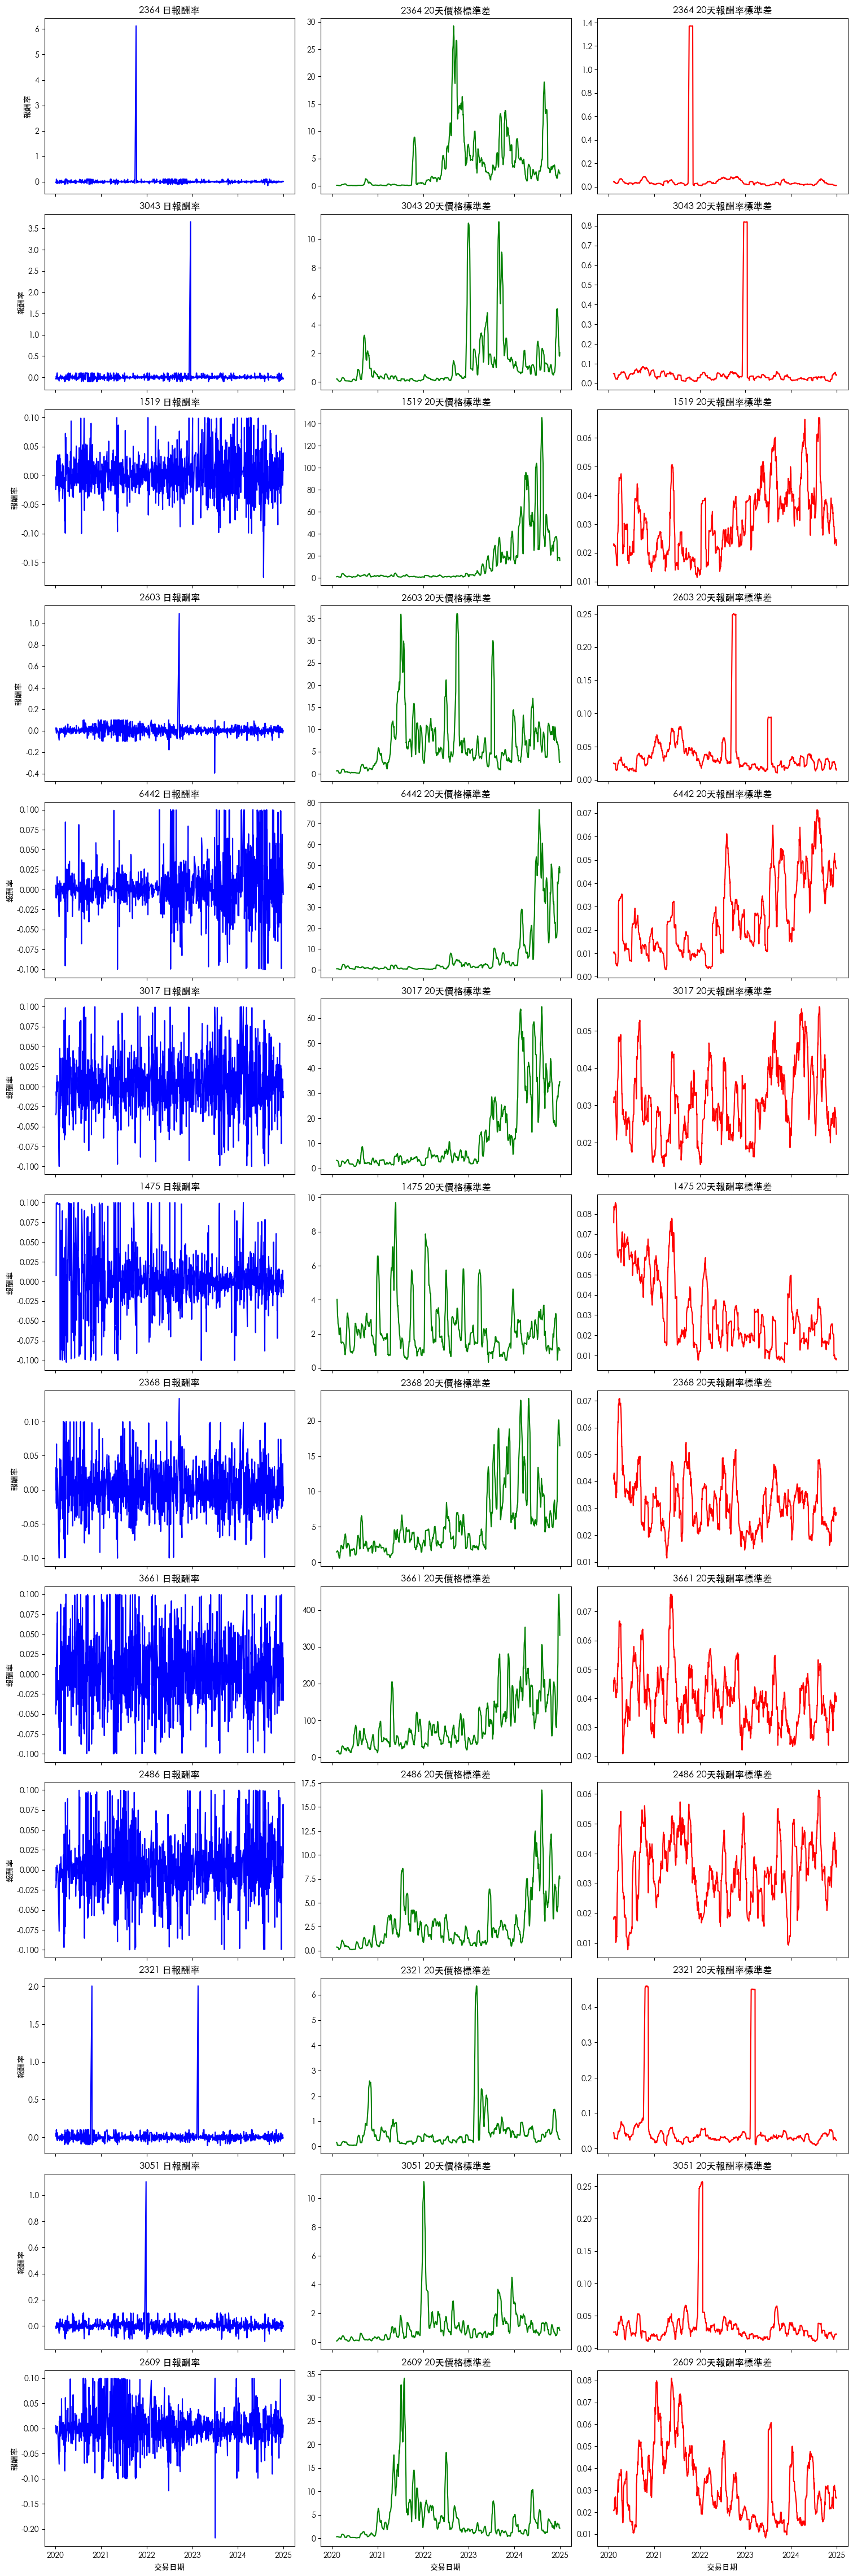

In [44]:
plot_returns_and_std_per_column(stock_2020_2024, top_1_percent.index, window=20)

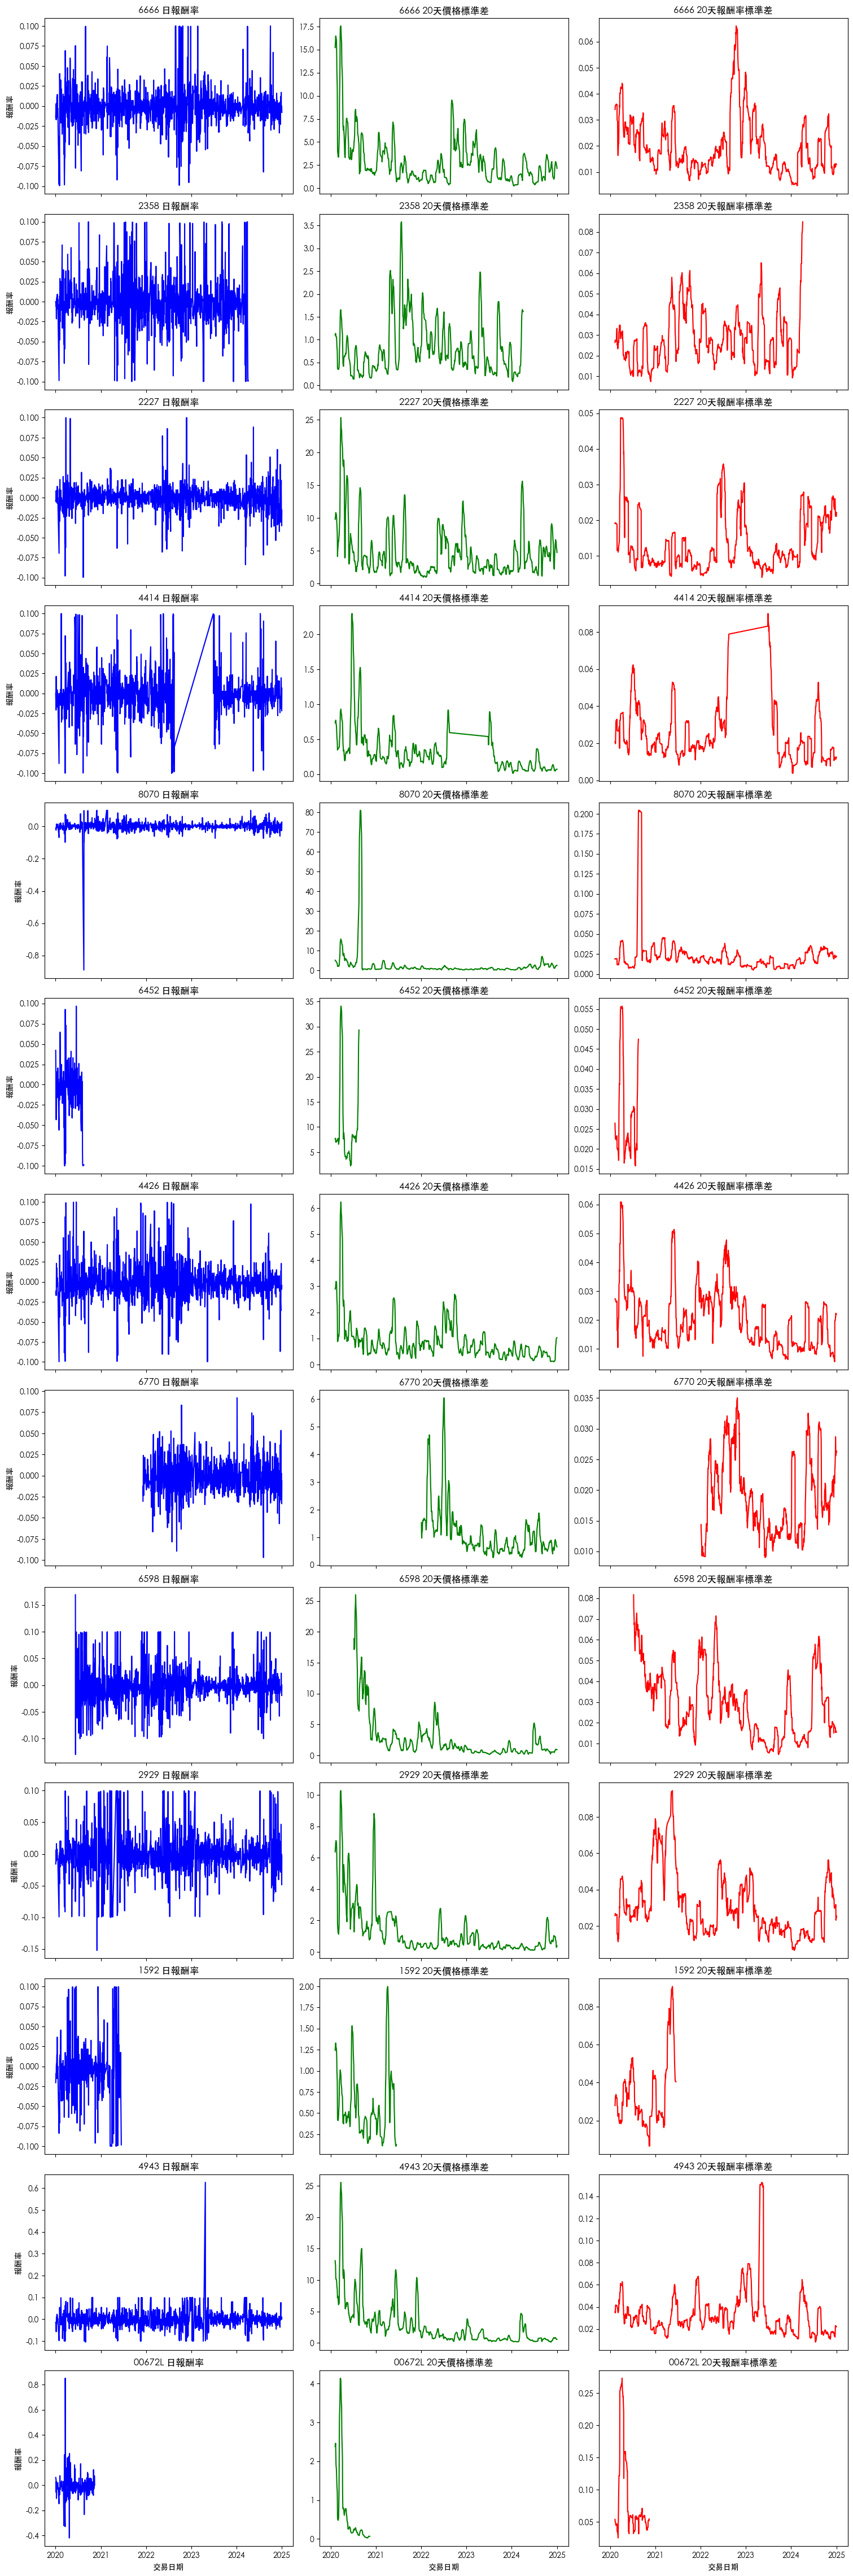

In [45]:
plot_returns_and_std_per_column(stock_2020_2024, last_1_percent.index, window=20)